In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import csv
import cv2

%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
dir = '../input/airbus-ship-detection/'

# **Training data**

In [4]:
train_df = pd.read_csv(dir + "train_ship_segmentations_v2.csv")
train_df

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


## Count Ships

In [5]:
train_df['ShipCount'] = train_df.groupby('ImageId')['ImageId'].transform('count')
train_df.loc[train_df['EncodedPixels'].isnull().values,'ShipCount'] = 0

In [6]:
train_df

,ImageId,EncodedPixels,ShipCount
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,5
...,...,...,...
231718,fffedbb6b.jpg,NaN,0
231719,ffff2aa57.jpg,NaN,0
231720,ffff6e525.jpg,NaN,0
231721,ffffc50b4.jpg,NaN,0


# Image Enhancement

In [60]:
sampleList = ['001234638.jpg','001aee007.jpg','001f04ca3.jpg','000d26c17.jpg']
sampleImgList = []
for x in sampleList:
    sampleImgList.append(mpimg.imread(dir + 'train_v2/' + x))

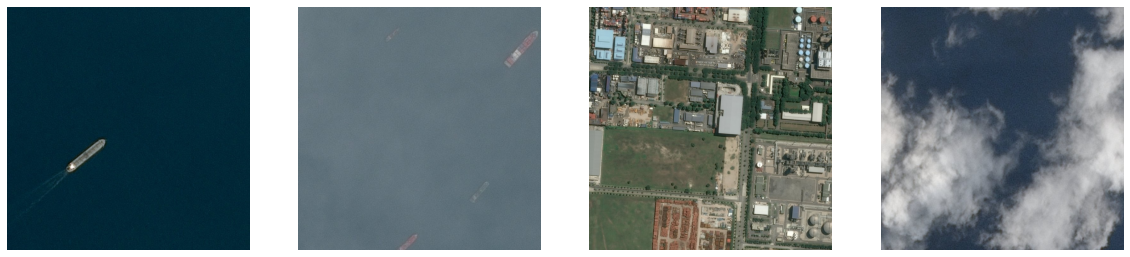

In [62]:
fig = plt.figure(1,figsize=(20,10))
for i in range(len(sampleImgList)):
    image_tmp = sampleImgList[i]
    ax = fig.add_subplot(1,4,i+1)
    ax.axis('off')
    ax.imshow(image_tmp)

In [52]:
from skimage.feature import canny
from skimage.filters import scharr, unsharp_mask
from skimage import exposure
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value

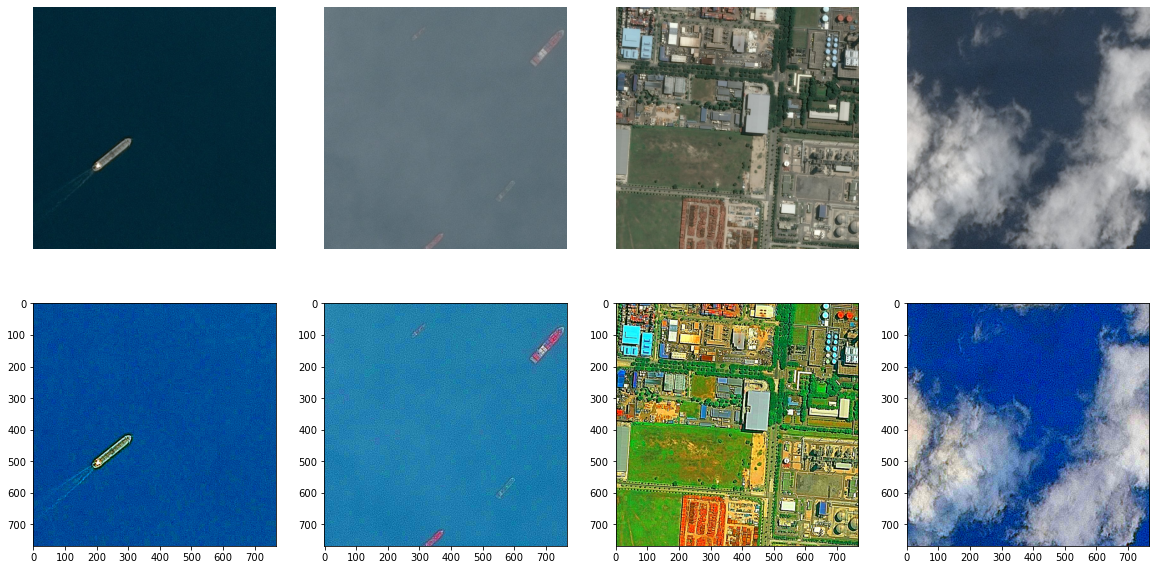

In [80]:
fig = plt.figure(1,figsize=(20,20))
for i in range(len(sampleImgList)):
    image_tmp = sampleImgList[i]
    ax = fig.add_subplot(2,4,i+1)
    ax.axis('off')
    ax.imshow(image_tmp)
    image_tmp = unsharp_mask(sampleImgList[i], radius=2, amount=5)
    sampleImgList[i] = image_tmp
    ax = fig.add_subplot(1,4,i+1)
    ax.imshow(image_tmp)

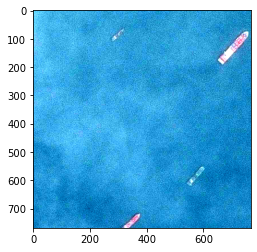

In [17]:
p2, p98 = np.percentile(image, (2, 98))
img_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))
plt.imshow(img_rescale)

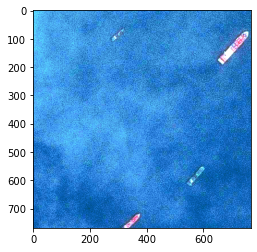

In [19]:
img_eq = exposure.equalize_hist(image)
plt.imshow(img_eq)

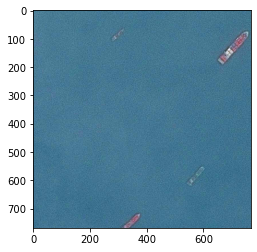

In [26]:
result_1 = unsharp_mask(image, radius=5, amount=2)
plt.imshow(result_1)